In [ ]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Dataset

In this notebook we are using the `YOOCHOOSE dataset` which contains a collection of sessions from a retailer, where each session is encapsulating the click events that the user performed in that session.

The dataset is available on [Kaggle](https://www.kaggle.com/chadgostopp/recsys-challenge-2015).

- Import required libraries

In [2]:
import os
import pandas as pd
import numpy as np
import gc

import cudf
import cupy
import nvtabular as nvt
from nvtabular import ColumnSelector

In [3]:
DATA_FOLDER = "/workspace/yoochoose/"
FILENAME_PATTERN = 'yoochoose-clicks.dat'
DATA_PATH = os.path.join(DATA_FOLDER, FILENAME_PATTERN)

In [4]:
OUTPUT_FOLDER = "/workspace/yoochoose/sessions_by_day"
!mkdir -p $OUTPUT_FOLDER

In [5]:
MINIMUM_SESSION_LENGTH = 2

### Loading data

In [6]:
#List of columns names to be used for CSV without the header line
HEADLESS_CSV_COLUMN_NAMES = ['session_id','timestamp', 'item_id', 'category']

In [7]:
interactions_df = cudf.read_csv(DATA_PATH, sep=',', names=HEADLESS_CSV_COLUMN_NAMES)

- Convert timestamp from datetime

In [8]:
interactions_df['event_time_dt'] = interactions_df['timestamp'].astype('datetime64[s]')
interactions_df['event_time_ts']= interactions_df['event_time_dt'].astype('int')

In [9]:
interactions_df = interactions_df.drop(['timestamp'], axis=1)

### Removing consecutive repeated interactions

In [10]:
print("Count with in-session repeated interactions: {}".format(len(interactions_df)))
# Sorts the dataframe by session and timestamp, to remove consective repetitions
interactions_df = interactions_df.sort_values(['session_id', 'event_time_ts'])

interactions_df['item_id_past'] = interactions_df['item_id'].shift(1).fillna(0)
interactions_df['session_id_past'] = interactions_df['session_id'].shift(1).fillna(0)
#Keeping only no consectutive repeated in session interactions
interactions_df = interactions_df[~((interactions_df['session_id'] == interactions_df['session_id_past']) & \
                 (interactions_df['item_id'] == interactions_df['item_id_past']))]
print("Count after removed in-session repeated interactions: {}".format(len(interactions_df)))

Count with in-session repeated interactions: 33003944
Count after removed in-session repeated interactions: 28971544


In [11]:
del(interactions_df['item_id_past'])
del(interactions_df['session_id_past'])
gc.collect()

### Include the item first time seen feature (for recency calculation)

In [12]:
items_first_ts_df = interactions_df.groupby('item_id').agg({'event_time_ts': 'min'}).reset_index().rename(columns={'event_time_ts': 'itemid_ts_first'})
interactions_merged_df = interactions_df.merge(items_first_ts_df, on=['item_id'], how='left')

In [13]:
interactions_merged_df.head()

,session_id,item_id,category,event_time_dt,event_time_ts,itemid_ts_first
0,3906,214716997,0,2014-04-01 11:00:46,1396350046,1396325069
1,3906,214716930,0,2014-04-01 11:02:31,1396350151,1396321473
2,3907,214535595,0,2014-04-05 21:25:39,1396733139,1396335529
3,3907,214535617,0,2014-04-05 21:25:56,1396733156,1396329369
4,3908,214832670,0,2014-04-01 14:49:54,1396363794,1396326727


- Check out if there is any column with missing values

In [14]:
interactions_merged_df.isnull().any()

session_id         False
item_id            False
category           False
event_time_dt      False
event_time_ts      False
itemid_ts_first    False
dtype: bool

In [ ]:
items_first_ts_df = None
del(items_first_ts_df)
gc.collect()

### Temporal features

In [15]:
# create time features
sessionTime = ['event_time_dt']

sessionTime_hour = (
    sessionTime >> 
    #nvt.ops.LambdaOp(lambda col: cudf.to_datetime(col, unit='ms').dt.hour) >> 
    nvt.ops.LambdaOp(lambda col: col.dt.hour) >> 
    nvt.ops.Rename(name = "event_time_hour")
)
sessionTime_weekday = (
    sessionTime >> 
    #nvt.ops.LambdaOp(lambda col: cudf.to_datetime(col, unit='ms').dt.weekday) >> 
    nvt.ops.LambdaOp(lambda col: col.dt.weekday) >> 
    nvt.ops.Rename(name = "event_time_wd")
)
sessionTime_day = (
    sessionTime >> 
    nvt.ops.LambdaOp(lambda col: col.dt.day) >> 
    nvt.ops.Rename(name = "event_time_day")
)

In [16]:
def get_cycled_feature_value_sin(col, max_value):
    value_scaled = (col + 0.000001) / max_value
    value_sin = np.sin(2*np.pi*value_scaled)
    return value_sin

def get_cycled_feature_value_cos(col, max_value):
    value_scaled = (col + 0.000001) / max_value
    value_cos = np.cos(2*np.pi*value_scaled)
    return value_cos

In [17]:
hour_sin = sessionTime_hour >> (lambda col: get_cycled_feature_value_sin(col, 24)) >> nvt.ops.Rename(name = 'timestamp_hour_sin')
hour_cos = sessionTime_hour >> (lambda col: get_cycled_feature_value_cos(col, 24)) >> nvt.ops.Rename(name = 'timestamp_hour_cos')
weekday_sin = sessionTime_weekday >> (lambda col: get_cycled_feature_value_sin(col+1, 7)) >> nvt.ops.Rename(name = 'timestamp_wd_sin')
weekday_cos= sessionTime_weekday >> (lambda col: get_cycled_feature_value_cos(col+1, 7)) >> nvt.ops.Rename(name = 'timestamp_wd_cos')

In [18]:
cycled_features = hour_sin + hour_cos + weekday_sin + weekday_cos

- Calculate item recency 

In [19]:
# create custom operator
from nvtabular.ops import Operator

class ItemRecency(Operator):
    def transform(self, columns, gdf):
        for column in columns.names:
            col = gdf[column]
            item_first_timestamp = gdf['itemid_ts_first']
            delta_days = (col - item_first_timestamp) / (60*60*24)
            gdf[column + "_age_days"] = delta_days * (delta_days >=0)
        return gdf
            
    def output_column_names(self, columns):
        return ColumnSelector([column + "_age_days" for column in columns.names])
            
    def dependencies(self):
        return ["itemid_ts_first"]

In [20]:
recency_features = ["event_time_ts"] >> ItemRecency() 
recency_features_norm = recency_features >> nvt.ops.LogOp() >> nvt.ops.Normalize() >> nvt.ops.Rename(name = "timestamp_age_days_norm")

In [21]:
time_features = (
    sessionTime + 
    sessionTime_hour +
    sessionTime_day + 
    sessionTime_weekday +
    recency_features_norm + 
    cycled_features +
    ["event_time_ts"]
)

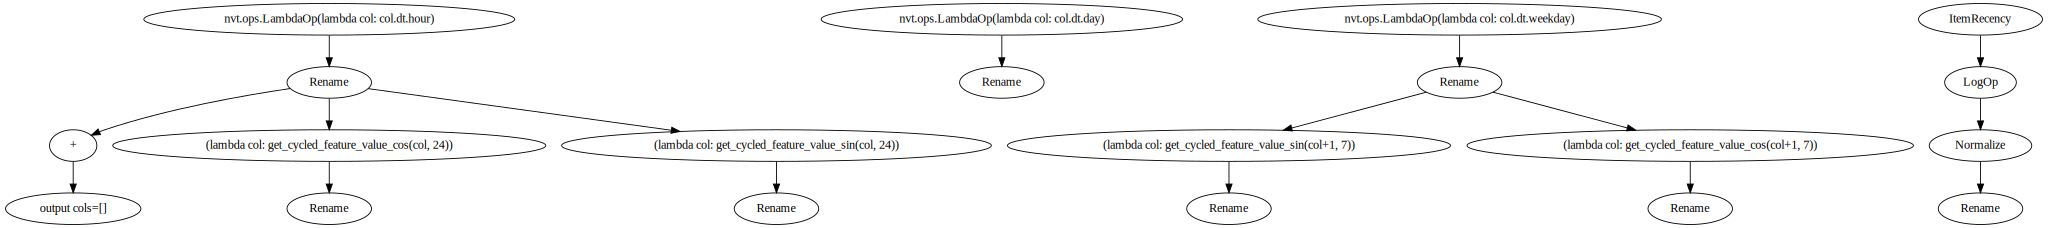

In [22]:
time_features.graph

### Categorify

In [23]:
categ_features = ['item_id', 'category'] >> nvt.ops.Categorify()

### Grouping interactions into sessions

In [24]:
groupby_feats = categ_features + ['session_id']+ time_features

In [25]:
# Define Groupby Workflow
groupby_features = groupby_feats >> nvt.ops.Groupby(
    groupby_cols=["session_id"], 
    sort_cols=["event_time_ts"],
    aggs={
        "item_id": ["list", "count"],
        "category": ["list"],        
        "event_time_dt": ["first"],
        "event_time_ts": ["first"],
        "timestamp_age_days_norm": ["list"],
        "timestamp_hour_sin": ["list"],
        "timestamp_hour_cos": ["list"],
        "timestamp_wd_sin": ["list"],
        "timestamp_wd_cos": ["list"],
        },
    name_sep="-")

In [26]:
groupby_features_list = groupby_features['item_id-list', 'category-list', 'timestamp_age_days_norm-list', 'timestamp_wd_sin-list',
                                         'timestamp_hour_cos-list','timestamp_wd_cos-list', 'timestamp_hour_sin-list']

In [27]:
groupby_features_trim = groupby_features_list >> nvt.ops.ListSlice(0,20) >> nvt.ops.Rename(postfix = '_trim')

In [28]:
# calculate session day index based on 'event_time_dt-first' column
day_index = ((groupby_features['event_time_dt-first'])  >> 
    nvt.ops.LambdaOp(lambda col: (col - col.min()).dt.days +1) >> 
    nvt.ops.Rename(f = lambda col: "day_index")
)

In [29]:
day_padded = day_index >> (lambda col: col.astype(str).str.pad(4,fillchar='0')) >> nvt.ops.Rename(f = lambda col: "day_padded")

In [30]:
selected_features = groupby_features['session_id', 'item_id-count', 'event_time_ts-first'] + groupby_features_trim + day_padded

In [31]:
filtered_sessions = selected_features >> nvt.ops.Filter(f=lambda df: df["item_id-count"] >= MINIMUM_SESSION_LENGTH)

- Initialize workflow object and transform the dataset

In [32]:
workflow = nvt.Workflow(filtered_sessions)
dataset = nvt.Dataset(interactions_merged_df, cpu=False)
workflow.fit(dataset)
sessions_gdf = workflow.transform(dataset).to_ddf().compute()

/root/.local/lib/python3.8/site-packages/numba-0.54.0rc2-py3.8-linux-x86_64.egg/numba/cuda/compiler.py:865: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (160) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [33]:
sessions_gdf.head(2)

,session_id,item_id-count,event_time_ts-first,item_id-list_trim,category-list_trim,timestamp_age_days_norm-list_trim,timestamp_wd_sin-list_trim,timestamp_hour_cos-list_trim,timestamp_wd_cos-list_trim,timestamp_hour_sin-list_trim,day_padded
0,1,4,1396867869,"[3559, 7340, 19523, 15499]","[1, 1, 1, 1]","[-1.3044713, -1.2986491, -1.3283161, -1.3548527]","[0.7818321, 0.7818321, 0.7818321, 0.7818321]","[-0.8660256, -0.8660256, -0.8660256, -0.8660256]","[0.6234891, 0.6234891, 0.6234891, 0.6234891]","[0.49999964, 0.49999964, 0.49999964, 0.49999964]",0007
1,2,5,1396878997,"[1968, 8039, 5178, 9410, 605]","[1, 1, 1, 1, 1]","[-1.3023784, -2.2679915, -2.1763284, -2.169367...","[0.7818321, 0.7818321, 0.7818321, 0.7818321, 0...","[-0.96592575, -0.96592575, -0.96592575, -0.866...","[0.6234891, 0.6234891, 0.6234891, 0.6234891, 0...","[-0.2588193, -0.2588193, -0.2588193, -0.500000...",0007


### Exporting session by day 

#### Saving using hive-partitioned data

In [35]:
PARTITION_COL = 'day_padded'

# Convert to a Dataset and write out hive-partitioned data to disk
nvt_output_path_tmp ='./output_nvt_tmp/'
workflow.transform(dataset).to_parquet(nvt_output_path_tmp, partition_on=[PARTITION_COL])

#### Converting to the HF4Rec dir structure and splitting dataset

- Rename columns to match with the yaml file

In [36]:
rename_cols = ['session_id', 'session_size', 'event_time_ts-first', 'item_id-list', 'category-list',  'timestamp_age_days_norm-list', 
               'timestamp_wd_sin-list', 'timestamp_hour_cos-list', 'timestamp_wd_cos-list', 'timestamp_hour_sin-list']

- Create the folder structure to be able to do daily training and evaluation

In [ ]:
days_folders = [f for f in sorted(os.listdir(nvt_output_path_tmp)) if f.startswith(PARTITION_COL)]
for day_folder in days_folders:
    df = cudf.read_parquet(os.path.join(nvt_output_path_tmp, day_folder))
    df = df.sort_values('event_time_ts-first')
    df.columns = rename_cols
    out_folder = os.path.join(OUTPUT_FOLDER, day_folder.replace('day_padded=', ''))
    os.makedirs(out_folder, exist_ok=True)
    df.to_parquet(os.path.join(out_folder, 'train.parquet'))
    
    random_values = np.random.rand(len(df))
    
    #Extracts 10% for valid and test set. Those sessions are also in the train set, but as evaluation
    #happens only for the subsequent day of training, that is not an issue, and we can keep the train set larger.
    valid_set = df[random_values <= 0.10]
    valid_set.to_parquet(os.path.join(out_folder, 'valid.parquet'))
    
    test_set = df[random_values >= 0.90]
    test_set.to_parquet(os.path.join(out_folder, 'test.parquet'))

- check out one processed parquet file

In [46]:
df = cudf.read_parquet(os.path.join(OUTPUT_FOLDER, '0001/train.parquet'))
df.head()

,session_id,session_size,event_time_ts-first,item_id-list,category-list,timestamp_age_days_norm-list,timestamp_wd_sin-list,timestamp_hour_cos-list,timestamp_wd_cos-list,timestamp_hour_sin-list
31230,351646,2,1396321200,"[556, 574]","[1, 1]","[-3.0278223, -3.0278223]","[0.9749277, 0.9749277]","[0.70710653, 0.70710653]","[-0.22252177, -0.22252177]","[0.707107, 0.707107]"
34633,389654,5,1396321200,"[90, 4519, 90, 513, 90]","[1, 1, 1, 1, 1]","[-3.0278223, -3.0278223, -3.026238, -3.0273852...","[0.9749277, 0.9749277, 0.9749277, 0.9749277, 0...","[0.70710653, 0.70710653, 0.70710653, 0.7071065...","[-0.22252177, -0.22252177, -0.22252177, -0.222...","[0.707107, 0.707107, 0.707107, 0.707107, 0.707..."
18660,210798,12,1396321213,"[6593, 5068, 12213, 15581, 11431, 1731, 11431,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-3.0278223, -3.0278223, -3.0278223, -3.027822...","[0.9749277, 0.9749277, 0.9749277, 0.9749277, 0...","[0.70710653, 0.70710653, 0.70710653, 0.7071065...","[-0.22252177, -0.22252177, -0.22252177, -0.222...","[0.707107, 0.707107, 0.707107, 0.707107, 0.707..."
33364,375257,11,1396321213,"[4133, 4034, 5093, 1117, 4068, 1117, 4068, 111...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-3.0278223, -3.0278223, -3.0278223, -3.027822...","[0.9749277, 0.9749277, 0.9749277, 0.9749277, 0...","[0.70710653, 0.70710653, 0.70710653, 0.7071065...","[-0.22252177, -0.22252177, -0.22252177, -0.222...","[0.707107, 0.707107, 0.707107, 0.707107, 0.707..."
15154,171168,2,1396321220,"[464, 576]","[1, 1]","[-3.0278223, -3.0278223]","[0.9749277, 0.9749277]","[0.70710653, 0.70710653]","[-0.22252177, -0.22252177]","[0.707107, 0.707107]"
